### Практикум

- [Генерация выборок](#step1)
- [t-критерий Стьюдента](#step2)
- [Проверка данных на нормальность](#step3)
- [Однофакторный дисперсионный анализ](#step4)
- [Однофакторный дисперсионный анализ типов лечения](#step5)
- [Двухфакторный дисперсионный анализ](#step6)
- [Хи-квадрат Пирсона](#step7)






In [1]:
import pandas as pd
import math
import random
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from bioinfokit.analys import stat
import pylab

### <a id='step1'> Генерация выборок </a>

### Генерация нормального распределения с numpy - массив array.

np.random.normal(loc=0, scale=1, size=None), где
- loc - среднее значение
- scale = среднеквадратическое отклонение
- size = число элементов

(array([  3.,   6.,  28.,  77., 136., 145., 103.,  68.,  24.,  10.]),
 array([-3.81076636, -2.57701914, -1.34327191, -0.10952468,  1.12422255,
         2.35796977,  3.591717  ,  4.82546423,  6.05921145,  7.29295868,
         8.52670591]),
 <BarContainer object of 10 artists>)

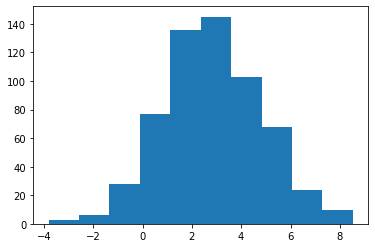

In [2]:
mu, sigma = 3, 2 # mean and стандартное отклонение
np_norm = np.random.normal(mu,sigma,600)
plt.figure(figsize=(6,4))
plt.hist(np_norm)

### <a id='step2'> t-критерий Стьюдента </a>

Предположим, что сравнивались выборки студентов первого и пятого курса по IQ. В таблице приведены статистики групп:

In [3]:
import pandas as pd
import math
from scipy import stats
import numpy as np

columns = ['курс', 'N', 'среднее', 'стандартное отклонение']
data = [
    [1, 30, 103, 10.12],
    [5, 28, 109, 12.01]
]
df = pd.DataFrame(data=data, columns=columns)

Выдвинем гипотезы: 
- H0: IQ студентов 1 и 5 курса не отличается
- Н1: IQ студентов 1 и 5 курса отличается

### Вручную 

In [4]:
#найдем стандартную ошибку среднего
def se(row):
    sd = row['стандартное отклонение']
    N = row['N']
    return round(sd / math.sqrt(N), 2)
df['se'] = df.apply(se, axis=1)
df

,курс,N,среднее,стандартное отклонение,se
0,1,30,103,10.12,1.85
1,5,28,109,12.01,2.27


In [5]:
# рассчитаем t-критерий Стьюдента
t = (df['среднее'][0] - df['среднее'][1]) / math.sqrt(df['стандартное отклонение'][0]**2/df['N'][0]+df['стандартное отклонение'][1]**2/df['N'][1])

кол-во степеней свободы - 56, значит при t = -2.050 p-value < 0.05 (по таблице критических значений)

### Результат: отвергаем нулевую гипотезы, IQ студентов 1 и 5 различается

### С помощью scipy.stats.ttest_ind()

In [6]:
# сгенерируем выборки со средним и sd как в таблице df чтобы применить scipy.stats.ttest_ind()
sample_1 = stats.norm.rvs(loc=103,scale=10.12,size=30)
sample_2 = stats.norm.rvs(loc=109,scale=12.01,size=28)
result = stats.ttest_ind(sample_1,sample_2)
print(result)
if result.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу, p-value =', '{:.3f}'.format(result.pvalue ))
else:
    print('Нет оснований для отвержения нулевой гипотезы при выбранном уровне статистической значимости, p-value=', '{:.3f}'.format(result.pvalue ))

Ttest_indResult(statistic=-2.060240897809144, pvalue=0.044033430136224745)
Отвергаем нулевую гипотезу, p-value = 0.044


### <a id='step3'> Проверка данных на нормальность </a>

In [7]:
df_1 = pd.read_excel('shapiro.xlsx')
df_1.columns = [c.lower() for c in df_1.columns]
df_1

,случай,количество решенных задач
0,1,41
1,2,42
2,3,48
3,4,61
4,5,56
5,6,53
6,7,47
7,8,58
8,9,49
9,10,51


In [8]:
shapiro_test = stats.shapiro(df_1['количество решенных задач'])
if shapiro_test.pvalue > 0.05:
    print('нет оснований отвергнуть нулевую гипотезу, предполагаем, что распределение нормальное')
else:
    print('отвергаем нулевую гипотезу')

нет оснований отвергнуть нулевую гипотезу, предполагаем, что распределение нормальное


In [9]:
# с помощью асимптоты и экспоненты
print(df_1['количество решенных задач'].kurtosis()) 
df_1['количество решенных задач'].skew() 

0.15989598986031828


-0.17098888661244258

< 1, значит, есть основания полагать, что распределение нормальное

### <a id='step4'>Однофакторный дисперсионный анализ</a>

<img src='gen.png'>

1. Определяем p-value однофакторного теста ANOVA (stats.f_oneway if <0.05 признаем различия по группам статистически значимыми)
2. Применяем критерий Тьюки для попарных сравнение по группам (или Тьюки-Крамера, если выборки разные по размеру)
3. Проверяем данные: 
- на нормальность распределения признака по группам (sns.problot, stats.shapiro)
- на гомогенность дисперсии (stats.bartlett()критерий Барлетта (для нормального распределения) или Левина from bioinfokit.analys import stat)
4. Выводы

In [10]:
df = pd.read_csv('gen.csv')
df.head()
# выделим группы по типу лечения
A = df.query('Therapy == "A"')['expr']
B = df.query('Therapy == "B"')['expr']
C = df.query('Therapy == "C"')['expr']
D = df.query('Therapy == "D"')['expr']

Text(0, 0.5, 'Экспрессия')

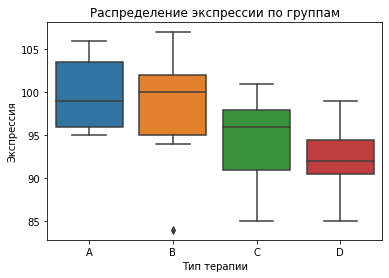

In [11]:
# посмотрим на распределение значений по группам
sns.boxplot(x='Therapy', y='expr', data=df)
plt.title('Распределение экспрессии по группам')
plt.xlabel('Тип терапии')
plt.ylabel('Экспрессия')

проведем ANOVA тест
- Н0: уровень экспрессии гена по группам не отличается
- Н1: уровень экспрессии гена по группам отличается

In [12]:
# scipy.stats вариант
res = stats.f_oneway(A, B,C,D)
if res.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований для отвержения нулувой гипотезы')

res = stat()
res.anova_stat(df=df, res_var='expr', anova_model='expr ~ C(Therapy)')
res.anova_summary

Отвергаем нулевую гипотезу


,df,sum_sq,mean_sq,F,PR(>F)
C(Therapy),3.0,560.716667,186.905556,8.037302,0.000152
Residual,56.0,1302.266667,23.254762,NaN,NaN


### Уровень p-value оказался меньше уровня значимости, что указывает на наличие статистически значимых различий в экспрессии генов по группам лечения

In [13]:
# с помощью критерия Тьюки сравним группы между собой
res = stat()
res.tukey_hsd(df = df, res_var='expr', xfac_var='Therapy', anova_model='expr ~ C(Therapy)' )
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,0.933333,-3.729420,5.596087,0.749595,0.900000
1,A,C,5.333333,0.670580,9.996087,4.283398,0.018896
2,A,D,7.400000,2.737246,12.062754,5.943214,0.001000
3,B,C,4.400000,-0.262754,9.062754,3.533803,0.071157
4,B,D,6.466667,1.803913,11.129420,5.193620,0.002948
5,C,D,2.066667,-2.596087,6.729420,1.659817,0.629585


Судя по результатам теста, статистически значимые различия обнаружены между группами:
- A и C
- A и D
- B и D

### Проверим данные на соблюдение требований Anova
- нормальность
- гомогенность дисперсии

((array([-1.69372899, -1.22918025, -0.93620006, -0.70737068, -0.51078428,
         -0.33229293, -0.1638693 ,  0.        ,  0.1638693 ,  0.33229293,
          0.51078428,  0.70737068,  0.93620006,  1.22918025,  1.69372899]),
  array([85, 87, 89, 90, 91, 91, 92, 92, 93, 94, 94, 95, 96, 97, 99])),
 (3.9634760412165226, 92.33333333333333, 0.9949553952632524))

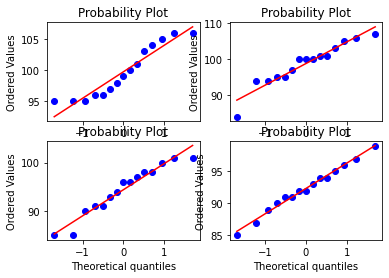

In [14]:
# построим графики qq-plot для каждой группы 
plt.subplot(2,2,1)
stats.probplot(A, plot=pylab)
plt.subplot(2,2,2)
stats.probplot(B, plot=pylab)
plt.subplot(2,2,3)
stats.probplot(C, plot=pylab)
plt.subplot(2,2,4)
stats.probplot(D, plot=pylab)

проверим нормальность распределения признака по группам с помощью Shapiro:
- Н0: нет оснований считать, что признак распределен не нормально
- H1: признак распределен не нормально

In [15]:
for group in df['Therapy'].unique():
    res = df[df['Therapy'] == group]['expr']
    print(group,': p-value:' , round((stats.shapiro(res).pvalue),2))

A : p-value: 0.06
B : p-value: 0.24
C : p-value: 0.26
D : p-value: 1.0


p-value во всех случаях превысил порог значимости, то есть нет оснований считать, что признак распределен не нормально

In [16]:
# проверим гомогенность дисперсии. 
# В данном случае признак распределен нормально, поэтому будет использован критерий критерий Бартлетта

#stats.barlett
res = stats.bartlett(A,B,C,D)
print(res.pvalue)

#bioinfokit.analys
res = stat()
res.bartlett(df=df, res_var='expr', xfac_var='Therapy')
res.bartlett_summary

0.32704502315643685


,Parameter,Value
0,Test statistics (T),3.452
1,Degrees of freedom (Df),3.000
2,p value,0.327


### Данные не позволяют отвергуть гипотезу о гомогенности дисперсии

### Результат ANOVA: **удалось выявить статистически значимую взаимосвязь** типа терапии с показателем уровня экспрессии гена. 
F(3,56) = 8.04, p<0.05

### Ручной расчет



Порядок расчета:
1. Находим среднее по всем Элементам
2. Рассчитываем SST (total sum of square)  - показатель изменчивости наших данных 
3. Рассчитываем степени свободы для SST: df = N-1
4. Рассчитываем SSW - показатель (внутригрупповая сумма квадратов)  - сумма отклонений от среднего внутри группы.
Считаем среднее для каждой группы. Вычитаем из каждого элемента группы среднее значение. 
5. Рассчитываем степени свободы для SSW: df = N-m
6. Рассчитываем SSB (межгрупповая сумма квадратов)  - сумма отклонений среднего группы от среднего по всем группам. 
7. Рассчитываем степени свободы для SSB: df = m-1
8. Рассчитываем Mwg - внутригрупповой средний квадрат: Mwg = SSW / df(wg)
9. Рассчитываем Mbg - межгрупповой средний квадрат: Mbg = SSB / df(bg)
10. Рассчитываем F-значение Фишера: F = Mbg / Mwg

**Интерпретация**: если бОльшая часть изменчивости обеспечивается за счет межгрупповой суммы квадратов, значит, что изменчивость обеспечивается за счет различий по группам  

In [17]:
# среднее по всем Э
mean_total = df['expr'].sum() / len(df['expr'])

In [18]:
#рассчитаем SST (total sum of square - показатель изменчивости данных)
counter = 0
for i in df['expr']:
    res = (i - mean_total)**2
    counter += res

In [19]:
# рассчитаем SSW - внутригрупповая сумма квадратов
# 1. найдем среднее по каждой группе
df_group = df.groupby(['Therapy']).agg('mean').reset_index()

# 2. найдем разницу для каждого элемента внутри группы
def wg_diff(group): #считает суммарный квадрат разницы для каждой группы 
    counter_1 = 0
    df_gr = df[df['Therapy'] == group] 
    for i in df_gr['expr']:
        res = (i - df_gr['expr'].mean())**2
        counter_1 += res
    return counter_1
SSW = 0
# 3. сложим результаты по всем группам
for group in df['Therapy'].unique():
    res = wg_diff(group)
    SSW = SSW + res     
# 4. рассчитаем степени свободы : df_wg = N-m 
df_wg = df.shape[0] - df['Therapy'].unique().size

In [20]:
# рассчитаем SSB - межгрупповая сумма квадратов
# нужно вычесть из среднего по группе общее среднее и умножить на кол-во элементов
df_gr = df.groupby('Therapy').agg(['count', 'mean'])
df_gr.columns = ['N', 'mean']
df_gr['ssb'] = (df_gr['mean'] - mean_total)**2 * df_gr['N']
SSB = df_gr['ssb'].sum()
# рассчитаем степени свободы : df_bg = m-1
df_bg = df['Therapy'].unique().size - 1

In [21]:
# Рассчитываем Mwg - внутригрупповой средний квадрат: Mwg = SSW / df(wg)
M_wg = SSW / df_wg

In [22]:
# Рассчитываем Mbg - межгрупповой средний квадрат: Mbg = SSB / df(bg)
M_bg = SSB / df_bg

In [23]:
# Рассчитываем F-значение Фишера: F = Mbg / Mwg
F = M_bg / M_wg
F

8.037302481143987

В таблице критических значений найдем **p-value: 0.0002**.
Так как p-value < 0.005, отвергаем нулевую гипотезу

Text(0, 0.5, 'экпрессия гена')

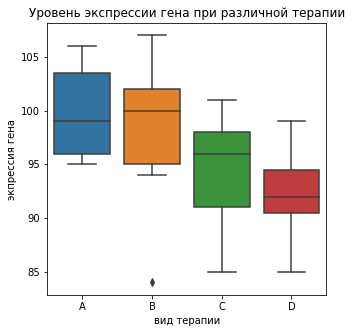

In [24]:
plt.figure(figsize=(5,5))
plt.title('Уровень экспрессии гена при различной терапии')
boxplot = sns.boxplot(data=df, x='Therapy', y='expr')
plt.xlabel('вид терапии')
plt.ylabel('экпрессия гена')

### <a id='step5'>Двухфакторный дисперсионный анализ</a>

<img src='birds.png'> 

In [26]:
df = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
df_melt = pd.melt(df, id_vars=['Genotype'], value_vars=['1_year', '2_year', '3_year'])
df_melt.columns = ['Genotype', 'years', 'value']
df_melt.head()

,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94


<AxesSubplot:xlabel='Genotype', ylabel='value'>

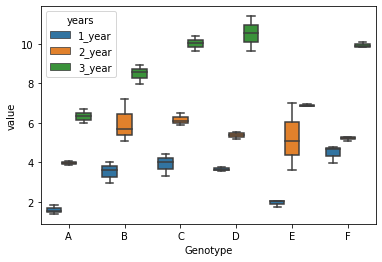

In [27]:
sns.boxplot(x='Genotype', y='value', hue='years', data=df_melt)

In [28]:
# многофакторный ANOVA (genotype&years)
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value~C(Genotype)+C(years)+C(Genotype):C(years)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Genotype),5.0,58.551733,11.710347,32.748581,1.931655e-12
C(years),2.0,278.925633,139.462817,390.014868,4.006243e-25
C(Genotype):C(years),10.0,17.122967,1.712297,4.788525,2.230094e-04
Residual,36.0,12.873000,0.357583,NaN,NaN


### значимые различия получены для генотипа, лет и взаимодействия этих факторов

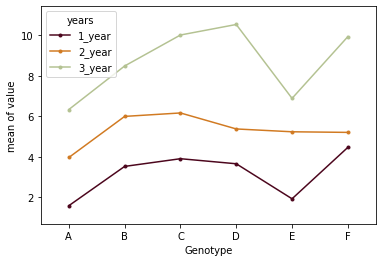

In [29]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=df_melt['Genotype'], trace=df_melt['years'], response=df_melt['value'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.show()

### Линейная регрессия

In [30]:
import pandas as pd
import numpy as np
from bioinfokit.analys import stat, get_data
import statsmodels.api as sm

df = get_data('plant_richness_lr').data
df.head(5)

,ntv_rich,area
0,1.897627,1.602060
1,1.633468,0.477121
2,2.597695,3.432488
3,2.238046,1.785330
4,2.712650,3.075547


In [31]:
X = df['area']
Y = df['ntv_rich']

X = sm.add_constant(X)

reg = sm.OLS(Y, X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ntv_rich   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     96.13
Date:                Fri, 11 Jun 2021   Prob (F-statistic):           4.40e-09
Time:                        11:18:16   Log-Likelihood:                 4.0471
No. Observations:                  22   AIC:                            -4.094
Df Residuals:                      20   BIC:                            -1.912
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3360      0.096     13.869      0.000       1.135       1.537
area           0.3557      0.036      9.805      0.000       0.280       0.431
==============================================================================
Omnibus:                        0.057   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.278
Skew:                          -0.033   Prob(JB):                        0.870
Kurtosis:                       2.453   Cond. No.                         6.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

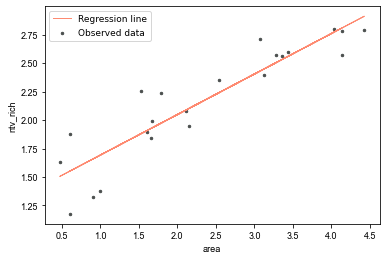

In [32]:
from bioinfokit import visuz
# get predicted Y and add to original dataframe
df['yhat']=reg.predict(X)
df.head(2)
# create regression plot with defaults
visuz.stat.regplot(df=df, x='area', y='ntv_rich', yhat='yhat', show=True)

In [33]:
df['res']=pd.DataFrame(reg.resid)
df['std_res']=reg.get_influence().resid_studentized_internal

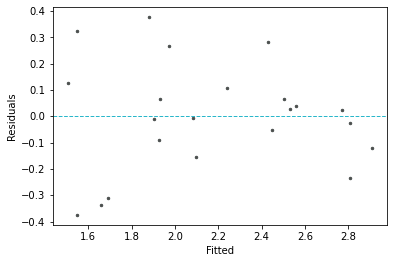

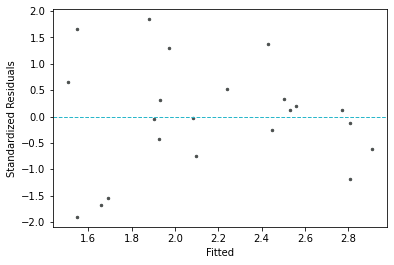

In [34]:
visuz.stat.reg_resid_plot(df=df, yhat='yhat', resid='res', stdresid='std_res', show=True)

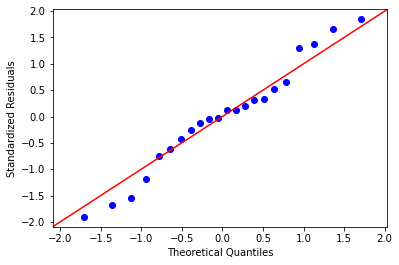

In [35]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
# create QQ plot
# line=45 option to plot the data around 45 degree line
sm.qqplot(df['std_res'], line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

### <a id='step7'>Хи-квадрат Пирсона</a>

Условия задачи:
<img src="pir.png" width=500/> 

Предполагается, что представители четырех разных специальностей различаются в успешности решения задач двух разных типов. Необходимо проверить гипотезу о различиях в частоте решения задач разного типа представителями разных специальностей. α = 0,05
- **H0**: представители разных специальностей решают задачи разных типов с одинаковой частотой (нет взаимосвязи между специальностью человека и его способностью решать определенный тип задач)
- **H1**: представители разных специальностей решают задачи разных типов с РАЗНОЙ частотой (ЕСТЬ взаимосвязь между специальностью человека и его способностью решать определенный тип задач)

In [36]:
#для расчета используется scipy.stats.chi2_contingency
obs = np.array([[26, 14],[16, 21],[20,23],[18,22]])
chi2, p, dof, ex = stats.chi2_contingency(obs)
print(f'Xи-квадрат Пирсона={chi2}, df={dof}, p-value={p}')

Xи-квадрат Пирсона=4.884978001257071, df=3, p-value=0.18041599111720938


### Полученный p-value преодолел порог статистической значимости, что не позволяет отвергнуть нулевую гипотезу. Т.е., подтвердить гипотезу о различии не удалось  

In [37]:
obs = [[16, 24], [22,18]]
chi2, p, dof, ex = stats.chi2_contingency(obs)
print(f'Xи-квадрат Пирсона={chi2}, df={dof}, p-value={p}')

Xи-квадрат Пирсона=1.2531328320802007, df=1, p-value=0.26295496582343514


In [38]:
obs = np.array([30,40,40,50])

In [39]:
stats.chisquare(obs)

Power_divergenceResult(statistic=5.0, pvalue=0.1717971442967335)

In [40]:
obs = [[5,25,10,8,3], [11,12,19,5,7]]
chi2, p, dof, ex = stats.chi2_contingency(obs)
print(f'Xи-квадрат Пирсона={chi2}, df={dof}, p-value={p}')

Xи-квадрат Пирсона=11.826919050232945, df=4, p-value=0.01868583819588996
